In [ ]:
import albumentations as A 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd 

In [2]:
df = pd.read_csv("/home/ian/datasets/totalsegmentator/train_organ_classification_kfold.csv")
df["plane"] = df.sid_plane.apply(lambda x: x.split("_")[1])
df = df.loc[df.plane == "coronal"]
df.head()

,adrenal_gland_left_label,adrenal_gland_right_label,aorta_label,atrial_appendage_left_label,autochthon_left_label,autochthon_right_label,brachiocephalic_trunk_label,brachiocephalic_vein_left_label,brachiocephalic_vein_right_label,brain_label,...,sid,outer,inner0,inner1,inner2,inner3,inner4,fold,sid_plane,plane
117,0,0,0,0,0,0,0,0,0,0,...,s0588,3,4,4,4,-1,4,3,s0588_coronal,coronal
118,0,0,0,0,0,0,0,0,0,0,...,s0588,3,4,4,4,-1,4,3,s0588_coronal,coronal
119,0,0,0,0,0,0,0,0,0,0,...,s0588,3,4,4,4,-1,4,3,s0588_coronal,coronal
120,0,0,0,0,0,0,0,0,0,0,...,s0588,3,4,4,4,-1,4,3,s0588_coronal,coronal
121,0,0,0,0,0,0,0,0,0,0,...,s0588,3,4,4,4,-1,4,3,s0588_coronal,coronal


In [3]:
img_data_dir = "/home/ian/datasets/totalsegmentator/pngs_for_slice_organ_classification/"
seg_data_dir = "/home/ian/datasets/totalsegmentator/segs_for_slice_organ_classification/"

In [4]:
df_list = [_df for _, _df in df.groupby("sid_plane")]
sampled_df = df_list[np.random.randint(len(df_list))]
sampled_df = sampled_df.sort_values("filename")

In [5]:
img_files = sampled_df.filename.tolist()
stack = [cv2.imread(os.path.join(img_data_dir, imfi), cv2.IMREAD_UNCHANGED) for imfi in img_files]
masks = [cv2.imread(os.path.join(seg_data_dir, imfi), cv2.IMREAD_GRAYSCALE) for imfi in img_files]
print(len(stack))

202


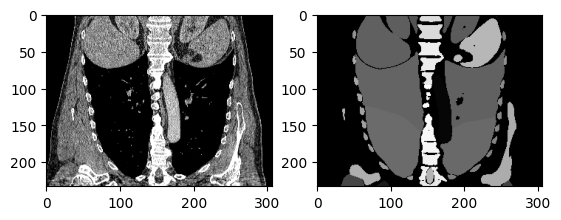

In [6]:
idx = np.random.randint(len(stack))
plt.subplot(1, 2, 1)
plt.imshow(stack[idx][:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(masks[idx], cmap="gray")
plt.show()

(233, 306) (271, 356)


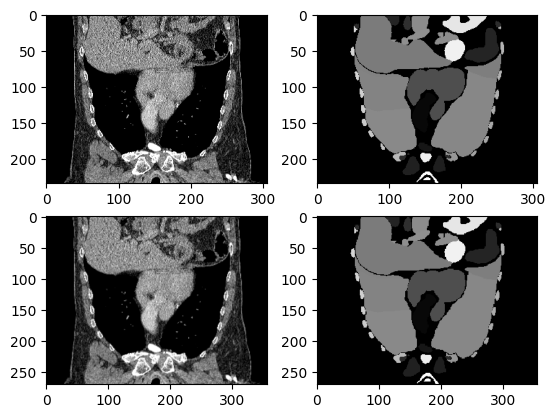

(271, 356) (224, 224)


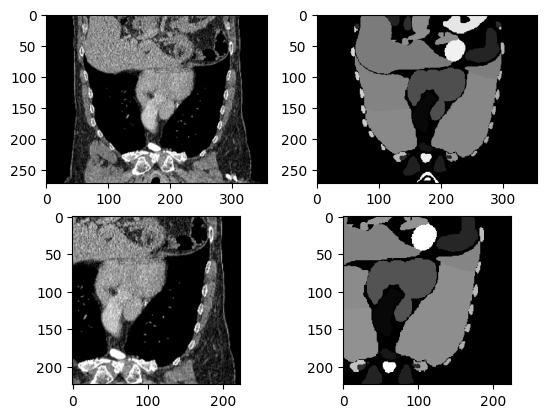

In [7]:
# TotalSegmentator dataset has been resampled to 1.5^3 mm isotropic voxels
# Typical studies will have slices of shape 512 x 512 pixels with variable slice thickness
# To simulate different slice thicknesses, can sample every 2nd/3rd slice (3 mm, 4.5 mm)
# To simulate different within-slice scales (i.e., pixel spacing), can rescale the image
# RandomScale from albumentations will randomly rescale the image by a factor sampled from scale_limit
# The value of scale_limit indicates the factor of scaling 
# i.e., 1.5 means the height and width of the final image is (1 + 1.5 = 2.5)x the original
# -0.5 means the height and width of the final image is (1 - 0.5 = 0.5)x the original
scaler = A.RandomScale(scale_limit=(-0.5, 1.5), p=1)

idx = np.random.randint(len(stack))
img, mask = stack[idx][:, :, 0], masks[idx]
trf = scaler(image=img, mask=mask)
img_aug = trf["image"]
mask_aug = trf["mask"]

print(img.shape, img_aug.shape)

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(mask, cmap="gray")
plt.subplot(2, 2, 3)
plt.imshow(img_aug, cmap="gray")
plt.subplot(2, 2, 4)
plt.imshow(mask_aug, cmap="gray")
plt.show()

# Then you can randomly crop a fixed size using RandomCrop
crop_size = (224, 224)
cropper = A.Compose(
    [A.PadIfNeeded(
        min_height=crop_size[0],
        min_width=crop_size[1],
        border_mode=cv2.BORDER_CONSTANT,
        p=1,
    ),
    A.RandomCrop(
        height=crop_size[0],
        width=crop_size[1],
        p=1,
    )]
)

trf = cropper(image=img_aug, mask=mask_aug)
cropped_img = trf["image"]
cropped_mask = trf["mask"]

print(img_aug.shape, cropped_img.shape)

plt.subplot(2, 2, 1)
plt.imshow(img_aug, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(mask_aug, cmap="gray")
plt.subplot(2, 2, 3)
plt.imshow(cropped_img, cmap="gray")
plt.subplot(2, 2, 4)
plt.imshow(cropped_mask, cmap="gray")
plt.show()

In [8]:
mask_stack = np.stack(masks, axis=0)
print(mask_stack.shape)

(202, 233, 306)


In [9]:
def map_values(arr, d):
    u, inv = np.unique(arr, return_inverse=True)
    return np.array([d[_] for _ in u])[inv].reshape(arr.shape)


def loop_translate(a, d):
    n = np.ndarray(a.shape)
    for k in d:
        n[a == k] = d[k]
    return n

In [ ]:
# Test how fast it is to map original labels to label subset
label_map = {0: 0}
for i in range(1, 118):
    label_map[i] = np.random.randint(1, 118)

vectorized_label_map = np.vectorize(label_map.__getitem__)

%timeit vectorized_label_map(mask_stack)
%timeit map_values(mask_stack, label_map)
%timeit loop_translate(mask_stack, label_map)

TypeError: '<' not supported between instances of 'int' and 'bytes'

In [22]:
dict_keys

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])